1.  a) True

    b) True

    c) False
    
    d) False
    
    e) False
    
    f) False
    
    g) True
    
    h) False
    
    i) True
    
    j) False
    
2. It works by recursively running a model and removing a predetermined amount of low importance features at a time to find the optimal number of features with the highest importance. 

3. It will replace missing values with mean value of the k closest neighbors

4. If the data is skewed or not normally distributed 

5. Month, Year, Quarter

6. In the case of working with imbalanced data, PR curve would be advantagous 

7. One-vs-one is leaving out data during the comparisons

8. c

9. Average ammount of transactions, repeated user transation, day of week

10. a) Yes, there are way less orange default circles than blue

    b) A majority of the orange circles are above the ~1750 balance mark with the blue circles becoming more sparce. a possible feature would be an over 1750 flag. 
    
11. c, d

12. d

13. Feature engineering is creating new predictor variables. feature selection is choosing which features to include in the model to moke predictions 

14. Reduce overfitting on small datasets, improve predictablity and interpretability

15. Model 2 because it has the best average performace accross all 5 folds
    


In [4]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.metrics import recall_score, classification_report, mean_squared_error
from sklearn.impute import SimpleImputer, KNNImputer
from scipy.stats import boxcox
from sklearn.feature_selection import RFE, RFECV
from sklearn.svm import SVC, SVR
from precision_recall_cutoff import precision_recall_cutoff

s3 = boto3.resource('s3')
bucket_name = 'grant-gonnerman-data-445'
bucket = s3.Bucket(bucket_name)

file_key = 'Customers.csv'

bucket_object = bucket.Object(file_key)
file_object = bucket_object.get()
file_content_stream = file_object.get('Body')

# reading data file
customers = pd.read_csv(file_content_stream)
customers.head()

,CustomerID,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,1,Male,19,15000,39,Healthcare,1,4
1,2,Male,21,35000,81,Engineer,3,3
2,3,Female,20,86000,6,Engineer,1,1
3,4,Female,23,59000,77,Lawyer,0,2
4,5,Female,31,38000,40,Entertainment,2,6


In [5]:
# dropping id
customers = customers.drop(columns = 'CustomerID', axis = 0)
customers.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Profession,Work Experience,Family Size
0,Male,19,15000,39,Healthcare,1,4
1,Male,21,35000,81,Engineer,3,3
2,Female,20,86000,6,Engineer,1,1
3,Female,23,59000,77,Lawyer,0,2
4,Female,31,38000,40,Entertainment,2,6


/tmp/ipykernel_7784/971530290.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(customers.corr(), cmap="crest")


<AxesSubplot: >

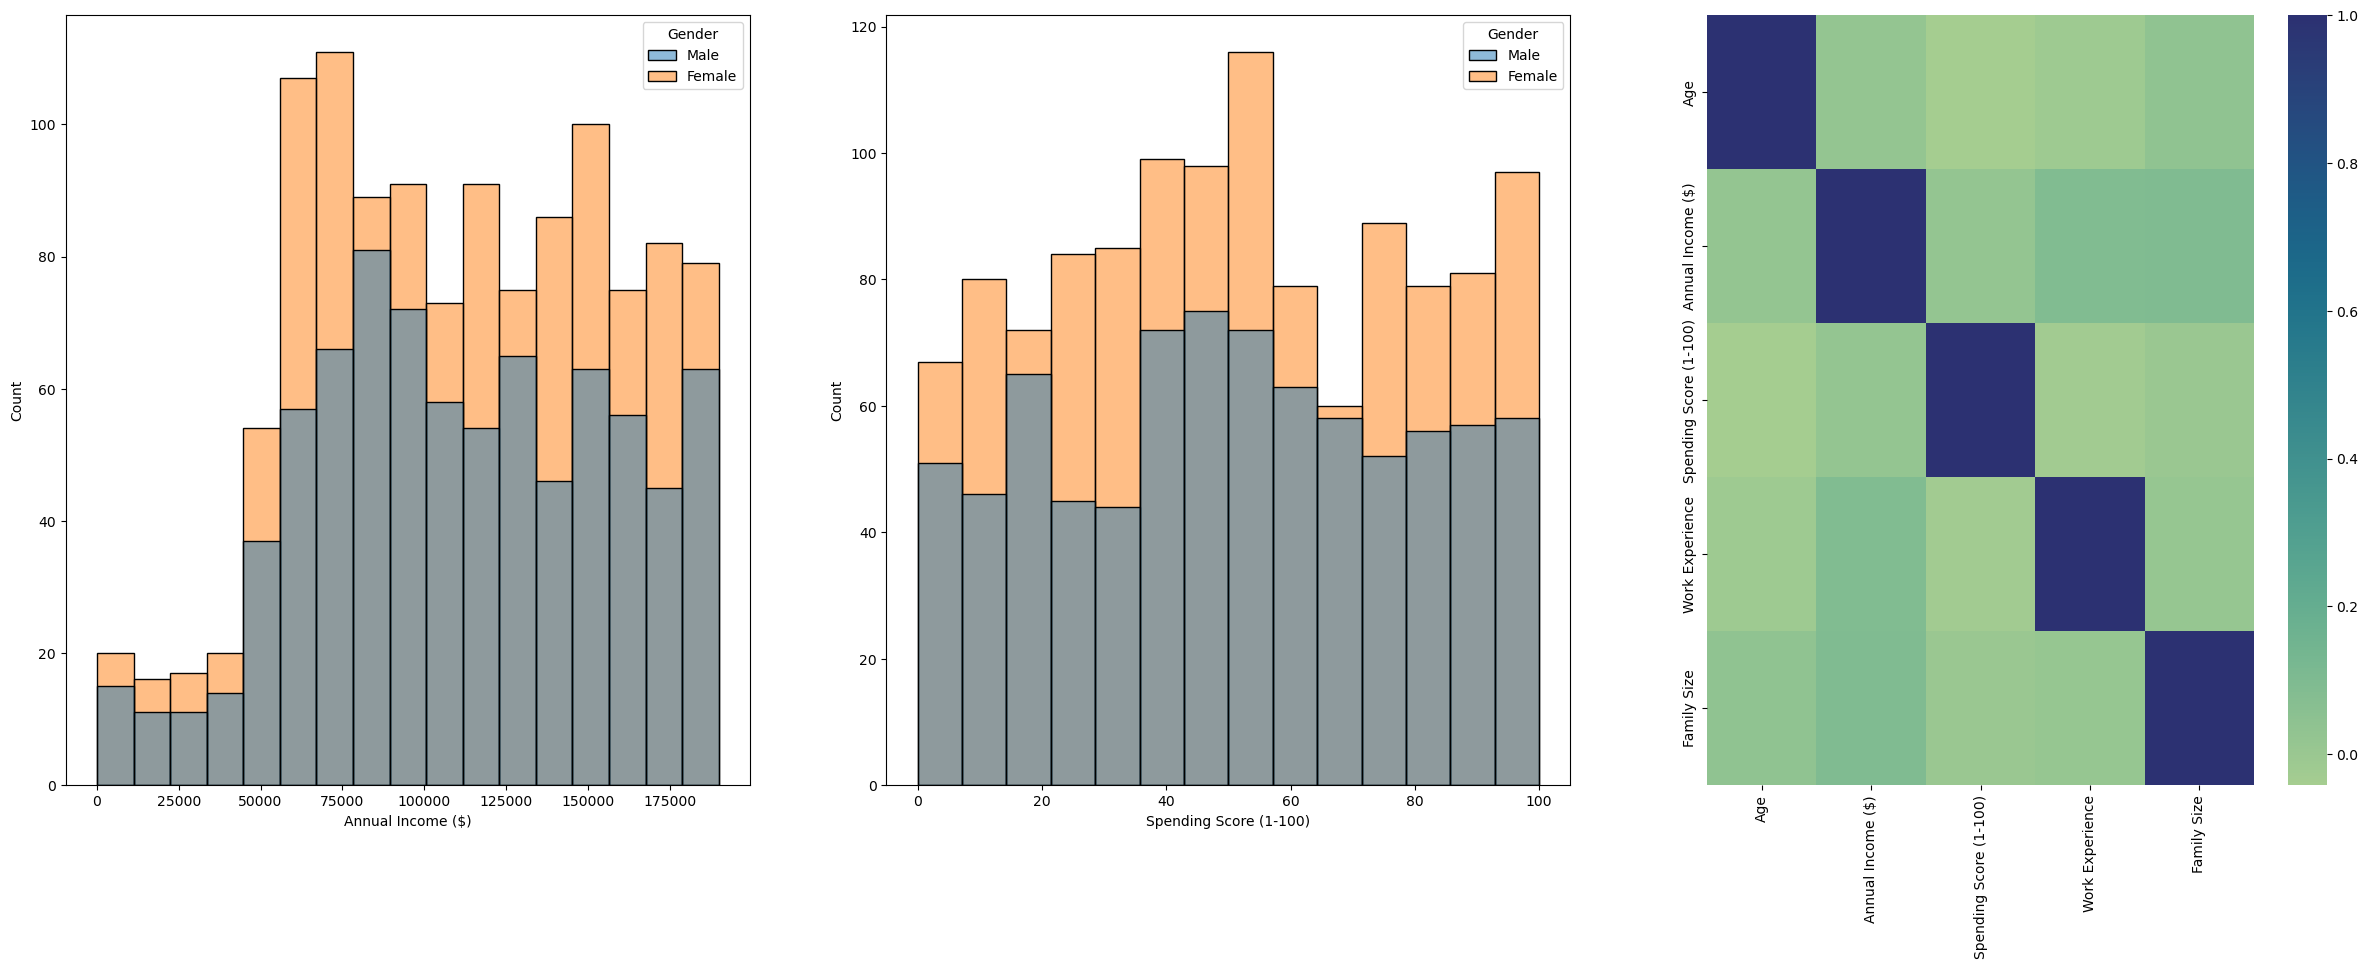

In [3]:
import seaborn as sns
fig, axes = plt.subplots(1, 3, figsize = (30, 10))
sns.histplot(ax = axes[0], x = 'Annual Income ($)', hue ='Gender', data = customers)
sns.histplot(ax = axes[1], x = 'Spending Score (1-100)', hue = 'Gender', data = customers)
sns.heatmap(customers.corr(), cmap="crest")

In [27]:
# from the first chart we can see most customers make above 50,000 in annual income and gender doesnt seem to play a huge role in imcome. slightly left skewed.
# the same can be said about the second chart but the data is more evenly distributed.
# the heat map does not show any interesting correlations among the predictor variables.

In [6]:
# changing Profession and Gender
customers['Gender'] = np.where(customers['Gender'] == 'Male', 1, 0)
customers = pd.concat([customers.drop(columns = 'Profession', axis =  1 ), pd.get_dummies(customers['Profession'])], axis = 1)
customers.head()

,Gender,Age,Annual Income ($),Spending Score (1-100),Work Experience,Family Size,Artist,Doctor,Engineer,Entertainment,Executive,Healthcare,Homemaker,Lawyer,Marketing
0,1,19,15000,39,1,4,0,0,0,0,0,1,0,0,0
1,1,21,35000,81,3,3,0,0,1,0,0,0,0,0,0
2,0,20,86000,6,1,1,0,0,1,0,0,0,0,0,0
3,0,23,59000,77,0,2,0,0,0,0,0,0,0,1,0
4,0,31,38000,40,2,6,0,0,0,1,0,0,0,0,0


In [7]:
# splitting customers into train and test
train, test = train_test_split(customers, test_size = 0.2)

# Feature Engineering

In [14]:
# defining imput and target
x = train.drop(columns = 'Spending Score (1-100)', axis = 0)
y = train['Spending Score (1-100)']

# list to store coefficents 
rf_importances = list()

for i in range(0, 50):
    # splitting the data into train and test 
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = .2)

    # building RF model
    rf_md = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(x_train, y_train)
    # extracting importances
    rf_importances.append(rf_md.feature_importances_)
    
rf_results = pd.DataFrame(rf_importances)
rf_results.columns = [x] 

avg_importance = pd.DataFrame({'RF Importance': np.mean(rf_results)})
avg_importance = avg_importance.sort_values(by = 'RF Importance', ascending = False)
avg_importance

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


,RF Importance
Annual Income ($),0.396717
Age,0.237505
Work Experience,0.156133
Family Size,0.086589
Gender,0.020832
Artist,0.017901
Healthcare,0.011991
Marketing,0.011775
Doctor,0.011521
Executive,0.011211


[Text(0.5, 0.875, 'Age <= 32.5\nsquared_error = 785.8000000000001\nsamples = 1600\nvalue = 50.931000000000004'),
 Text(0.25, 0.625, 'Annual Income ($) <= 169964.0\nsquared_error = 795.6\nsamples = 540\nvalue = 54.076'),
 Text(0.125, 0.375, 'Annual Income ($) <= 109566.0\nsquared_error = 786.6\nsamples = 466\nvalue = 55.758'),
 Text(0.0625, 0.125, 'squared_error = 770.1370000000001\nsamples = 255\nvalue = 52.741'),
 Text(0.1875, 0.125, 'squared_error = 782.212\nsamples = 211\nvalue = 59.403'),
 Text(0.375, 0.375, 'Family Size <= 1.5\nsquared_error = 722.331\nsamples = 74\nvalue = 43.486000000000004'),
 Text(0.3125, 0.125, 'squared_error = 427.78700000000003\nsamples = 13\nvalue = 25.538'),
 Text(0.4375, 0.125, 'squared_error = 701.821\nsamples = 61\nvalue = 47.311'),
 Text(0.75, 0.625, 'Annual Income ($) <= 151262.0\nsquared_error = 773.2040000000001\nsamples = 1060\nvalue = 49.329'),
 Text(0.625, 0.375, 'Doctor <= 0.5\nsquared_error = 775.95\nsamples = 814\nvalue = 48.129'),
 Text(0.56

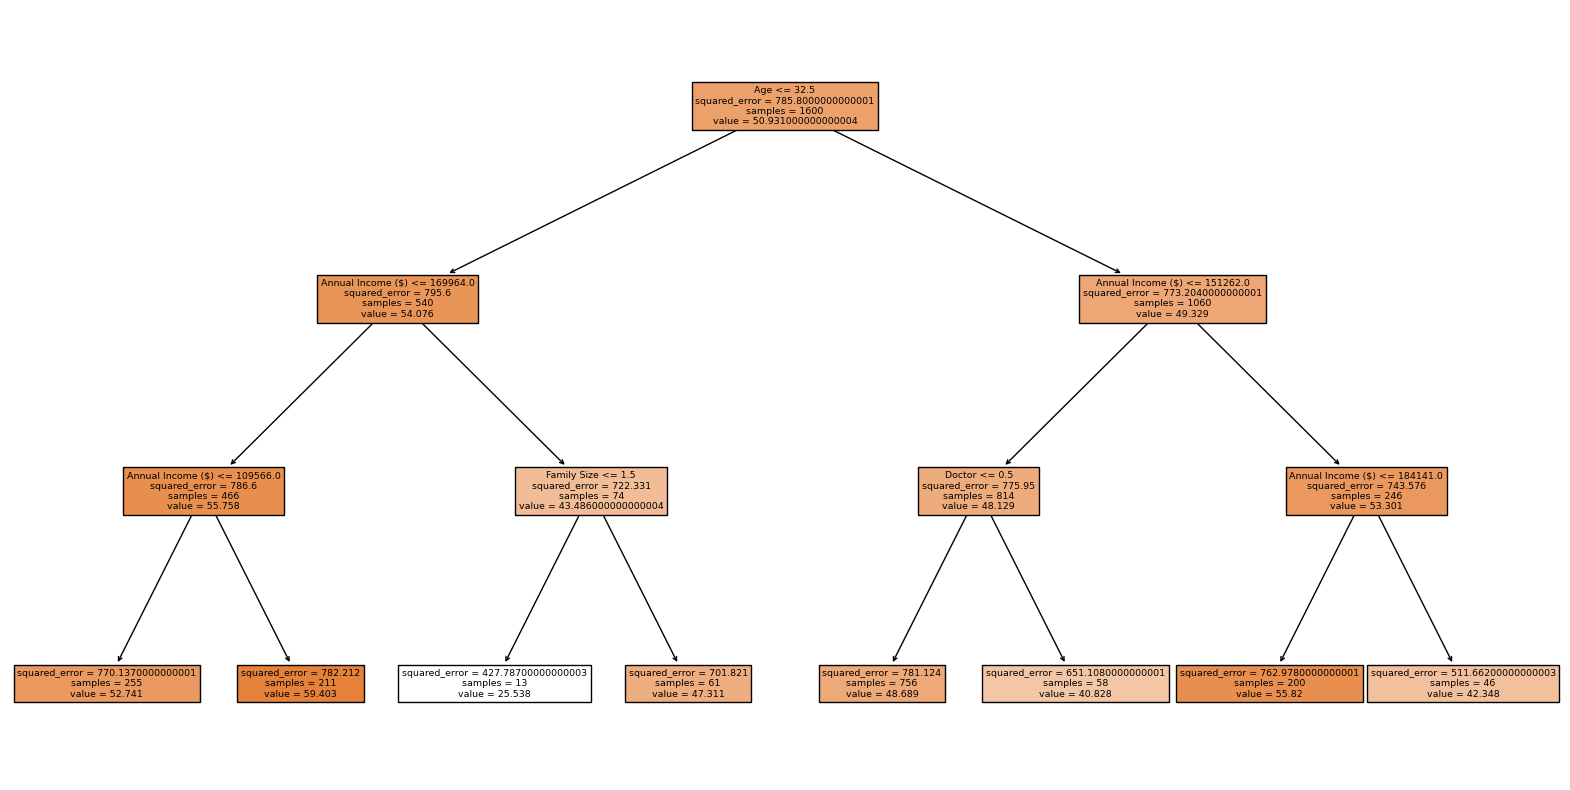

In [56]:
# defining imput and target
x = train.drop(columns = 'Spending Score (1-100)', axis = 0)
y = train['Spending Score (1-100)']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
# building decision tree
tree_md = DecisionTreeRegressor(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (20,10))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5, 0.875, 'Age <= 32.5\nsquared_error = 786.4\nsamples = 1600\nvalue = 51.165'),
 Text(0.25, 0.625, 'Annual Income ($) <= 150225.5\nsquared_error = 821.1560000000001\nsamples = 564\nvalue = 54.348'),
 Text(0.125, 0.375, 'Annual Income ($) <= 108255.5\nsquared_error = 808.8580000000001\nsamples = 410\nvalue = 57.015'),
 Text(0.0625, 0.125, 'squared_error = 784.01\nsamples = 261\nvalue = 52.843'),
 Text(0.1875, 0.125, 'squared_error = 768.5\nsamples = 149\nvalue = 64.322'),
 Text(0.375, 0.375, 'Age <= 0.5\nsquared_error = 784.537\nsamples = 154\nvalue = 47.247'),
 Text(0.3125, 0.125, 'squared_error = 48.222\nsamples = 3\nvalue = 89.667'),
 Text(0.4375, 0.125, 'squared_error = 762.7040000000001\nsamples = 151\nvalue = 46.404'),
 Text(0.75, 0.625, 'Annual Income ($) <= 155527.0\nsquared_error = 758.964\nsamples = 1036\nvalue = 49.432'),
 Text(0.625, 0.375, 'Annual Income ($) <= 149099.0\nsquared_error = 765.799\nsamples = 822\nvalue = 48.207'),
 Text(0.5625, 0.125, 'squared_error =

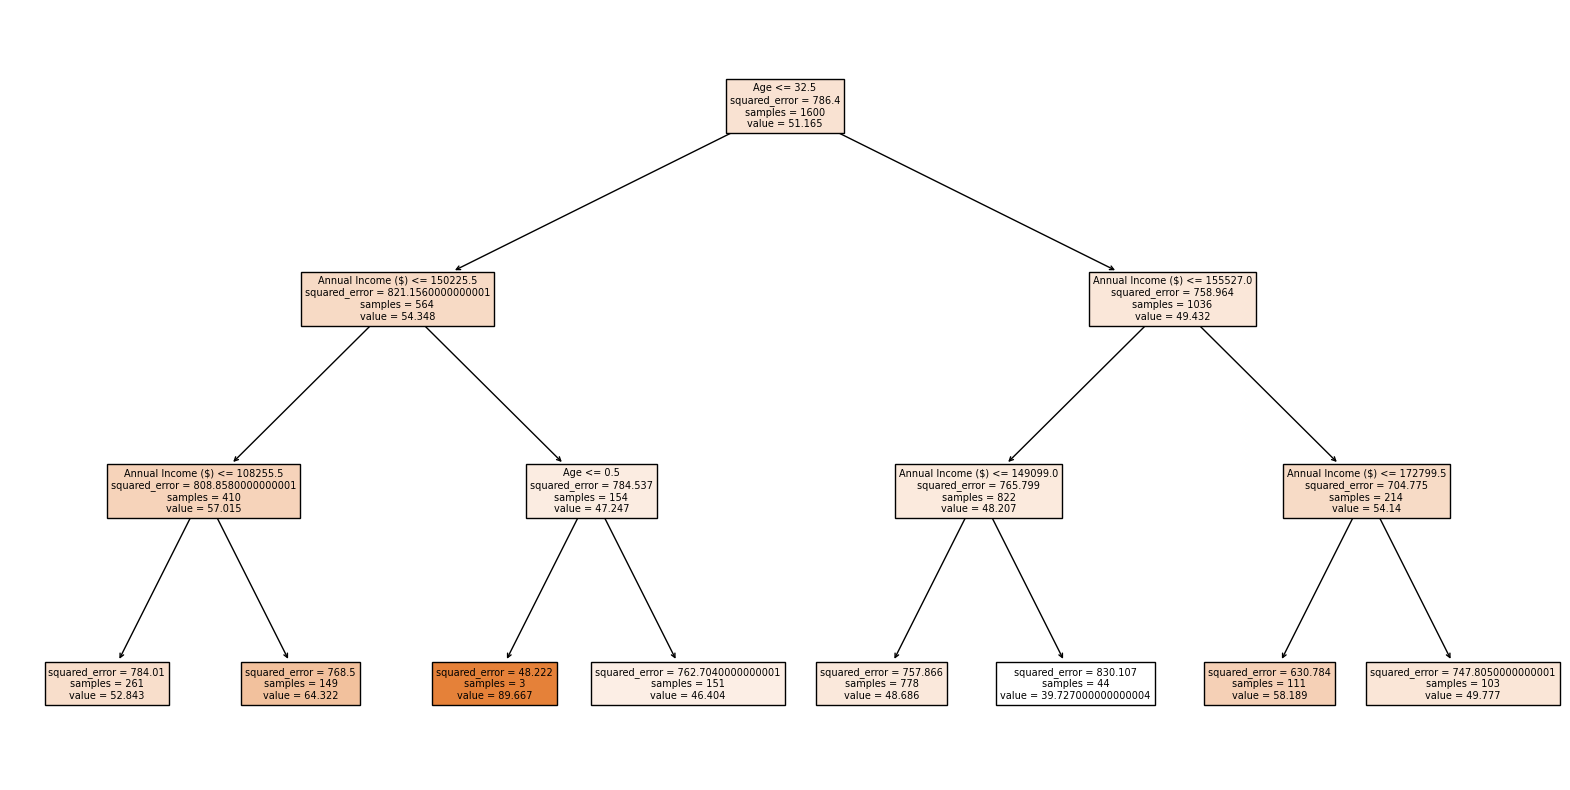

In [57]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
# building decision tree
tree_md = DecisionTreeRegressor(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (20,10))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

[Text(0.5, 0.875, 'Work Experience <= 8.5\nsquared_error = 778.758\nsamples = 1600\nvalue = 51.086'),
 Text(0.25, 0.625, 'Age <= 33.5\nsquared_error = 781.159\nsamples = 1330\nvalue = 51.777'),
 Text(0.125, 0.375, 'Annual Income ($) <= 59952.5\nsquared_error = 807.327\nsamples = 483\nvalue = 54.019'),
 Text(0.0625, 0.125, 'squared_error = 575.11\nsamples = 75\nvalue = 62.36'),
 Text(0.1875, 0.125, 'squared_error = 834.8720000000001\nsamples = 408\nvalue = 52.485'),
 Text(0.375, 0.375, 'Annual Income ($) <= 53311.5\nsquared_error = 761.74\nsamples = 847\nvalue = 50.499'),
 Text(0.3125, 0.125, 'squared_error = 700.982\nsamples = 76\nvalue = 43.789'),
 Text(0.4375, 0.125, 'squared_error = 762.854\nsamples = 771\nvalue = 51.161'),
 Text(0.75, 0.625, 'Artist <= 0.5\nsquared_error = 752.9590000000001\nsamples = 270\nvalue = 47.678000000000004'),
 Text(0.625, 0.375, 'Age <= 48.5\nsquared_error = 710.177\nsamples = 186\nvalue = 44.984'),
 Text(0.5625, 0.125, 'squared_error = 582.421\nsamples =

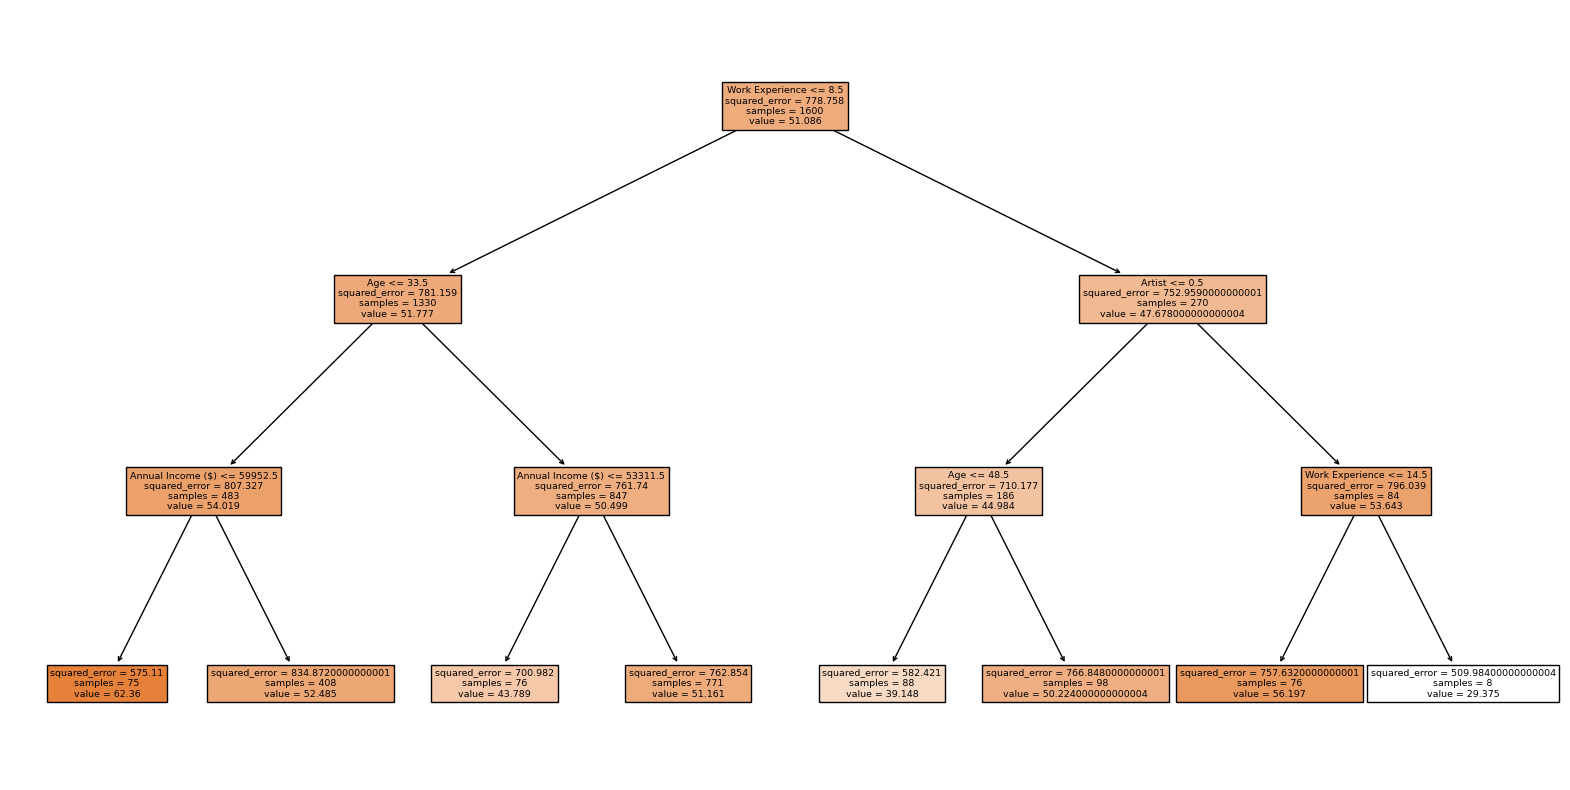

In [58]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2)
# building decision tree
tree_md = DecisionTreeRegressor(max_depth = 3).fit(x_train, y_train)

fig = plt.figure(figsize = (20,10))
plot_tree(tree_md, feature_names = x_train.columns, filled = True)

In [8]:
# engineering by strong heredity
train['heredity_1'] = train['Annual Income ($)'] * train['Age']
train['heredity_2'] = train['Annual Income ($)'] * train['Work Experience']

test['heredity_1'] = test['Annual Income ($)'] * test['Age']
test['heredity_2'] = test['Annual Income ($)'] * test['Work Experience']

# engineering by decision tree
train['DT_1'] = np.where((train['Work Experience'] <= 8.5) & (train['Age'] <= 33.5) & (train['Annual Income ($)'] <= 53311.5), 1, 0)
train['DT_2'] = np.where((train['Age'] <= 32.5) & (train['Annual Income ($)'] <= 149099), 1, 0)
train['DT_3'] = np.where((train['Age'] <= 32.5) & (train['Annual Income ($)'] <= 151262) & (train['Doctor'] <= .5), 1, 0)

test['DT_1'] = np.where((test['Work Experience'] <= 8.5) & (test['Age'] <= 33.5) & (test['Annual Income ($)'] <= 53311.5), 1, 0)
test['DT_2'] = np.where((test['Age'] <= 32.5) & (test['Annual Income ($)'] <= 149099), 1, 0)
test['DT_3'] = np.where((test['Age'] <= 32.5) & (test['Annual Income ($)'] <= 151262) & (test['Doctor'] <= .5), 1, 0)

# Modeling

In [ ]:
# defining imput and target
x = train.drop(columns = 'Spending Score (1-100)', axis = 0)
y = train['Spending Score (1-100)']

# lists to store supports 
rf_support = list()

for i in range(0,100):
    print(i)
    # splitting the data
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, stratify = y)
    
    ## Running RFECV with Random forest model
    rf_rfe = RFECV(estimator = RandomForestRegressor(n_estimators = 500, max_depth = 3), step = 1, min_features_to_select = 2, cv = 5).fit(x_train, y_train)
    rf_support.append(rf_rfe.support_)
    
rf_results = pd.DataFrame(rf_support)
rf_results.columns = x_train.columns

In [28]:
# rf features by percentage of importance
importances = pd.DataFrame({'Occurances':100*rf_results.apply(np.sum, axis = 0) / rf_results.shape[0]})
importances = importances.sort_values(by = 'Occurances', ascending = False)
importances

,Occurances
Annual Income ($),100.0
heredity_1,99.0
heredity_2,93.0
Age,78.0
DT_2,71.0
Work Experience,68.0
Family Size,67.0
DT_3,50.0
Gender,48.0
Artist,38.0


In [9]:
# defining input and target
x_train = train[['Annual Income ($)', 'heredity_1', 'heredity_1', 'Age', 'DT_2']]
y_train = train['Spending Score (1-100)']
x_test = test[['Annual Income ($)', 'heredity_1', 'heredity_1', 'Age', 'DT_2']]
y_test = test['Spending Score (1-100)']

# building random forest regressor
rf_md1 = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(x_train, y_train)

rf_pred1 = rf_md1.predict(x_test)

print(mean_squared_error(y_test, rf_pred1, squared = False))

28.53309204727088


In [11]:
# defining input and target
x_train2 = train[['Annual Income ($)', 'heredity_1', 'heredity_1', 'Age', 'DT_2', 'Work Experience']]
x_test2 = test[['Annual Income ($)', 'heredity_1', 'heredity_1', 'Age', 'DT_2', 'Work Experience']]

# building random forest regressor
rf_md2 = RandomForestRegressor(n_estimators = 500, max_depth = 3).fit(x_train2, y_train)

rf_pred2 = rf_md2.predict(x_test2)

print(mean_squared_error(y_test, rf_pred2, squared = False))

28.631075000515505


In [12]:
# based on the RMSE i would choose the first random forest regressor with 5 variables to predict spending score because it has a lower RMSE